In [10]:
import os
import sys


# Here you need to have same Python version on your local machine and on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [11]:
# Creating Spark Session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Assignment').getOrCreate()

In [12]:
import pyspark
import pandas as pd
import math
import scipy.stats.stats as stats
import pyspark.sql.functions as fun

from pyspark.sql.functions import col, countDistinct
from functools import reduce
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import lit, coalesce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import DoubleType

In [4]:
#Reading Data from a CSV file 
#Inferring Schema and Setting Header as True

credit_record = spark.read.csv("credit_record.csv", header=True, inferSchema=True)
credit_application = spark.read.csv("application_record.csv", header=True, inferSchema=True)

def spark_shape(self):
    return (self.count(), len(self.columns))

pyspark.sql.dataframe.DataFrame.shape = spark_shape

print(credit_record.shape())
print(credit_application.shape())

print(credit_record.dtypes)
print(credit_application.dtypes)

(1048575, 3)
(438557, 18)
[('ID', 'int'), ('MONTHS_BALANCE', 'int'), ('STATUS', 'string')]
[('ID', 'int'), ('CODE_GENDER', 'string'), ('FLAG_OWN_CAR', 'string'), ('FLAG_OWN_REALTY', 'string'), ('CNT_CHILDREN', 'int'), ('AMT_INCOME_TOTAL', 'double'), ('NAME_INCOME_TYPE', 'string'), ('NAME_EDUCATION_TYPE', 'string'), ('NAME_FAMILY_STATUS', 'string'), ('NAME_HOUSING_TYPE', 'string'), ('DAYS_BIRTH', 'int'), ('DAYS_EMPLOYED', 'int'), ('FLAG_MOBIL', 'int'), ('FLAG_WORK_PHONE', 'int'), ('FLAG_PHONE', 'int'), ('FLAG_EMAIL', 'int'), ('OCCUPATION_TYPE', 'string'), ('CNT_FAM_MEMBERS', 'double')]


In [5]:
credit_record.show()

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
+-------+--------------+------+
only showing top 20 rows



In [6]:
# Number of distinct applications 
credit_application.agg(countDistinct(col("ID")).alias("Applicants")).show()

#Number of distinct credit card customers
credit_record.agg(countDistinct(col("ID")).alias("CC-customers")).show()

#Pivot the monthly status to get customer view
credit_record_pivot = credit_record.groupBy("ID").pivot("STATUS").agg(fun.count('ID'))
credit_record_pivot.show()

+----------+
|Applicants|
+----------+
|    438510|
+----------+

+------------+
|CC-customers|
+------------+
|       45985|
+------------+

+-------+----+----+----+----+----+----+----+----+
|     ID|   0|   1|   2|   3|   4|   5|   C|   X|
+-------+----+----+----+----+----+----+----+----+
|5061822|   5|null|null|null|null|null|null|   1|
|5060509|  28|   1|null|null|null|null|null|   5|
|5009304|   5|null|null|null|null|null|   6|  24|
|5021819|  38|null|null|null|null|null|null|null|
|5044479|   2|null|null|null|null|null|null|   1|
|5092149|   1|null|null|null|null|null|null|   6|
|5135899|   6|null|null|null|null|null|  17|   7|
|5142868|  26|null|null|null|null|null|null|   1|
|5149573|   4|null|null|null|null|null|  33|null|
|5068077|   5|null|null|null|null|null|   1|null|
|5089546|  14|   1|null|null|null|null|null|   4|
|5090925|  10|null|null|null|null|null|null|   1|
|5112842|   6|null|null|null|null|null|   8|null|
|5005681|  13|null|null|null|null|null|  13|   5|
|5009033

In [7]:
#rename of pivoted columns
oldColumns = credit_record_pivot.schema.names
newColumns = ["ID","stat_0","stat_1","stat_2","stat_3","stat_4","stat_5","stat_C","stat_X"]
credit_record_pivot = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), credit_record_pivot)
credit_record_pivot.show()

+-------+------+------+------+------+------+------+------+------+
|     ID|stat_0|stat_1|stat_2|stat_3|stat_4|stat_5|stat_C|stat_X|
+-------+------+------+------+------+------+------+------+------+
|5061822|     5|  null|  null|  null|  null|  null|  null|     1|
|5060509|    28|     1|  null|  null|  null|  null|  null|     5|
|5009304|     5|  null|  null|  null|  null|  null|     6|    24|
|5021819|    38|  null|  null|  null|  null|  null|  null|  null|
|5044479|     2|  null|  null|  null|  null|  null|  null|     1|
|5092149|     1|  null|  null|  null|  null|  null|  null|     6|
|5135899|     6|  null|  null|  null|  null|  null|    17|     7|
|5142868|    26|  null|  null|  null|  null|  null|  null|     1|
|5149573|     4|  null|  null|  null|  null|  null|    33|  null|
|5068077|     5|  null|  null|  null|  null|  null|     1|  null|
|5089546|    14|     1|  null|  null|  null|  null|  null|     4|
|5090925|    10|  null|  null|  null|  null|  null|  null|     1|
|5112842| 

In [8]:
#Adding a number of times customer became delinquent 
DelColumns = ["stat_2","stat_3","stat_4","stat_5"]

def column_add(a,b):
    return a.__add__(b)

credit_record_pivot = credit_record_pivot.na.fill(0)
credit_record_pivot = credit_record_pivot.withColumn('total_del', reduce(column_add, ( credit_record_pivot[col] for col in DelColumns ) ))
credit_record_pivot.show()


#Create target variable
credit_record_pivot = credit_record_pivot.withColumn('target', fun.when(fun.col('total_del') > 0, 1).otherwise(0))
credit_record_pivot.show()

credit_record_pivot.groupby('target').count().show()

+-------+------+------+------+------+------+------+------+------+---------+
|     ID|stat_0|stat_1|stat_2|stat_3|stat_4|stat_5|stat_C|stat_X|total_del|
+-------+------+------+------+------+------+------+------+------+---------+
|5061822|     5|     0|     0|     0|     0|     0|     0|     1|        0|
|5060509|    28|     1|     0|     0|     0|     0|     0|     5|        0|
|5009304|     5|     0|     0|     0|     0|     0|     6|    24|        0|
|5021819|    38|     0|     0|     0|     0|     0|     0|     0|        0|
|5044479|     2|     0|     0|     0|     0|     0|     0|     1|        0|
|5092149|     1|     0|     0|     0|     0|     0|     0|     6|        0|
|5135899|     6|     0|     0|     0|     0|     0|    17|     7|        0|
|5142868|    26|     0|     0|     0|     0|     0|     0|     1|        0|
|5149573|     4|     0|     0|     0|     0|     0|    33|     0|        0|
|5068077|     5|     0|     0|     0|     0|     0|     1|     0|        0|
|5089546|   

In [9]:
#Merge both the dataframes

mergeCredit_app_record = credit_record_pivot.join(credit_application.alias('b'), credit_record_pivot.ID == credit_application.ID, 'inner').select('b.*', credit_record_pivot.target)
print(mergeCredit_app_record.shape())
mergeCredit_app_record = mergeCredit_app_record.na.drop()
print(mergeCredit_app_record.shape())

(36457, 19)
(25134, 19)


### What is the proportion of females in the applicant customer base

In [50]:
gender_count = credit_application.groupBy('CODE_GENDER').count().orderBy('count')
gender_count = gender_count.withColumn('proportion', fun.col('count')/fun.sum('count').over(Window.partitionBy()))
gender_count.show()

+-----------+------+------------------+
|CODE_GENDER| count|        proportion|
+-----------+------+------------------+
|          M|144117|0.3286163486160294|
|          F|294440|0.6713836513839706|
+-----------+------+------------------+



### Is house ownership higher among male applicants vs female applicants

In [51]:
credit_application_pivoted = credit_application.crosstab('NAME_HOUSING_TYPE','CODE_GENDER')
credit_application_pivoted.show()

+-----------------------------+------+------+
|NAME_HOUSING_TYPE_CODE_GENDER|     F|     M|
+-----------------------------+------+------+
|             Rented apartment|  3284|  2690|
|          Municipal apartment| 10019|  4195|
|             Office apartment|  2122|  1800|
|            House / apartment|267607|126224|
|              Co-op apartment|   862|   677|
|                 With parents| 10546|  8531|
+-----------------------------+------+------+



In [52]:
credit_application_pivoted = credit_application_pivoted.withColumn('prop_F', fun.col('F')/fun.sum('F').over(Window.partitionBy()))
credit_application_pivoted = credit_application_pivoted.withColumn('prop_M', fun.col('M')/fun.sum('M').over(Window.partitionBy()))

credit_application_pivoted.show()

+-----------------------------+------+------+--------------------+--------------------+
|NAME_HOUSING_TYPE_CODE_GENDER|     F|     M|              prop_F|              prop_M|
+-----------------------------+------+------+--------------------+--------------------+
|             Rented apartment|  3284|  2690|0.011153375900013585|0.018665389926240485|
|          Municipal apartment| 10019|  4195| 0.03402730607254449|0.029108293955605515|
|             Office apartment|  2122|  1800|0.007206901236245...|0.012489851995253856|
|            House / apartment|267607|126224|  0.9088676810216003|  0.8758439323605126|
|              Co-op apartment|   862|   677|0.002927591359869583|0.004697572111548...|
|                 With parents| 10546|  8531| 0.03581714440972694| 0.05919495965083925|
+-----------------------------+------+------+--------------------+--------------------+



### Is there any correlation between income levels and education level?

In [53]:
# Lower secondary = 0, Secondary / secondary special = 1, Incomplete higher = 2, Higher education = 3, Academic degree = 4
credit_application = credit_application.withColumn("NAME_EDUCATION_TYPE_cat", when(col("NAME_EDUCATION_TYPE")=='Lower secondary', 0).when(col("NAME_EDUCATION_TYPE")=='Secondary / secondary special', 1).when(col("NAME_EDUCATION_TYPE")=='Incomplete higher', 2).when(col("NAME_EDUCATION_TYPE")=='Higher education', 3).when(col("NAME_EDUCATION_TYPE")=='Academic degree', 4))

corr_data = credit_application.select('AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE_cat')

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print(corr_df.to_string())

                         AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE_cat
AMT_INCOME_TOTAL                 1.000000                 0.221403
NAME_EDUCATION_TYPE_cat          0.221403                 1.000000


### What is the average and median salary of the applicant base?

In [54]:
# Computing the mean
credit_application.select('AMT_INCOME_TOTAL').describe().show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            438557|
|   mean| 187524.2860095039|
| stddev|110086.85306622987|
|    min|           26100.0|
|    max|         6750000.0|
+-------+------------------+



In [55]:
# Computing the median
credit_application.approxQuantile("AMT_INCOME_TOTAL", [0.5], 0)

[160780.5]

### Do people owning cars have higher probability of bad customers

In [56]:
target_cars_customers = mergeCredit_app_record.groupby('FLAG_OWN_CAR', 'target').count().orderBy('FLAG_OWN_CAR')

pivoted = mergeCredit_app_record.groupby('FLAG_OWN_CAR').pivot("target", ['1', '0']).count()

pivoted.show()

+------------+---+-----+
|FLAG_OWN_CAR|  1|    0|
+------------+---+-----+
|           Y|177|10339|
|           N|245|14373|
+------------+---+-----+



In [57]:
row_count = sum(col(x) for x in ['1', '0'])

adjusted = [(col(y) / row_count).alias(y) for y in ['1', '0']]

In [58]:
pivoted.select(col("FLAG_OWN_CAR"), *adjusted).show()

+------------+--------------------+------------------+
|FLAG_OWN_CAR|                   1|                 0|
+------------+--------------------+------------------+
|           Y| 0.01683149486496767|0.9831685051350323|
|           N|0.016760158708441646|0.9832398412915584|
+------------+--------------------+------------------+



### Do people living on rent have a higher proportion of bad customers as compared to the rest of the population

In [59]:
mergeCredit_app_record.select("NAME_HOUSING_TYPE").distinct().show()

+-------------------+
|  NAME_HOUSING_TYPE|
+-------------------+
|  House / apartment|
|Municipal apartment|
|    Co-op apartment|
|   Rented apartment|
|   Office apartment|
|       With parents|
+-------------------+



In [60]:
mergeCredit_app_record = mergeCredit_app_record.withColumn('RENT_HOUSING_TYPE', fun.when(fun.col('NAME_HOUSING_TYPE') == 'Rented apartment', 'Rent').otherwise('Not Rent'))

target_cars_customers = mergeCredit_app_record.groupby('RENT_HOUSING_TYPE', 'target').count().orderBy('RENT_HOUSING_TYPE')

pivoted = mergeCredit_app_record.groupby('RENT_HOUSING_TYPE').pivot("target", ['1', '0']).count()

pivoted.show()

+-----------------+---+-----+
|RENT_HOUSING_TYPE|  1|    0|
+-----------------+---+-----+
|             Rent|  6|  433|
|         Not Rent|416|24279|
+-----------------+---+-----+



In [61]:
pivoted.select(col("RENT_HOUSING_TYPE"), *adjusted).show()

+-----------------+--------------------+------------------+
|RENT_HOUSING_TYPE|                   1|                 0|
+-----------------+--------------------+------------------+
|             Rent| 0.01366742596810934|0.9863325740318907|
|         Not Rent|0.016845515286495243|0.9831544847135048|
+-----------------+--------------------+------------------+



### Do single people have a high proportion of bad customers as compared to married customers

In [62]:
mergeCredit_app_record.select("NAME_FAMILY_STATUS").distinct().show()

+--------------------+
|  NAME_FAMILY_STATUS|
+--------------------+
|           Separated|
|             Married|
|Single / not married|
|               Widow|
|      Civil marriage|
+--------------------+



In [63]:
mergeCredit_app_record = mergeCredit_app_record.withColumn('MARRIED_STATUS', fun.when(fun.col('NAME_FAMILY_STATUS') == 'Married', 'Married').otherwise('Unmarried'))

target_cars_customers = mergeCredit_app_record.groupby('MARRIED_STATUS', 'target').count().orderBy('MARRIED_STATUS')

pivoted = mergeCredit_app_record.groupby('MARRIED_STATUS').pivot("target", ['1', '0']).count()

pivoted.show()

+--------------+---+-----+
|MARRIED_STATUS|  1|    0|
+--------------+---+-----+
|       Married|277|17232|
|     Unmarried|145| 7480|
+--------------+---+-----+



In [64]:
pivoted.select(col("MARRIED_STATUS"), *adjusted).show()

+--------------+-------------------+------------------+
|MARRIED_STATUS|                  1|                 0|
+--------------+-------------------+------------------+
|       Married|0.01582043520475184|0.9841795647952482|
|     Unmarried|0.01901639344262295| 0.980983606557377|
+--------------+-------------------+------------------+



In [13]:
# WOE & IV calculation by creating a class

class WOE_IV(object):
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {}

    def fit(self):
        for col_to_woe in self.cols_to_woe:
            total_good = self.compute_total_amount_of_good()
            total_bad = self.compute_total_amount_of_bad()
            
            woe_df = self.df.select(col_to_woe)
            categories = woe_df.distinct().collect()
            for category_row in categories:
                category = category_row[col_to_woe]
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)

                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist),
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist)
            }
        }

        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv']
        return iv_dict

In [17]:
#Creating monotonous bins for continous variables

spike_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']

max_bucket = 5

for x in spike_cols:
    r = 0
    n = max_bucket
    while ((np.abs(r) < 1) & (n>1)):
        discretizer = QuantileDiscretizer(numBuckets=n, inputCol=x, outputCol=x + "bucket")
        d1 = discretizer.fit(mergeCredit_app_record).transform(mergeCredit_app_record)
        d2 = d1.groupby(x+ "bucket").agg(F.mean(x).alias("X1"),F.mean("target").alias("Y1")).orderBy("X1")
        a1 = d2.select("X1").rdd.flatMap(lambda x: x).collect()
        b1 = d2.select("Y1").rdd.flatMap(lambda x: x).collect()
        r, p = stats.spearmanr(a1, b1)
        if(r == 1):
            print(x+"bucket")
            mergeCredit_app_record = discretizer.fit(mergeCredit_app_record).transform(mergeCredit_app_record)
        n = n-1
        
print(mergeCredit_app_record.columns)

AMT_INCOME_TOTALbucket
DAYS_EMPLOYEDbucket
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'target', 'AMT_INCOME_TOTALbucket', 'DAYS_EMPLOYEDbucket']


In [33]:
# Calculating WOE and IV for all the categorical variables (including bin variables from continous variables)


cols_to_woe = ['CODE_GENDER', 'FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
               'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE',
               'AMT_INCOME_TOTALbucket','DAYS_EMPLOYEDbucket']

woe = WOE_IV(mergeCredit_app_record, cols_to_woe, 'target', 1)

# woe encoding
woe.fit()
encoded_df = woe.transform(mergeCredit_app_record)

# information value
ivs = woe.compute_iv()

In [34]:
# print WOE for each variable & category
print(woe.fit_data)

{'CODE_GENDER': {'F': {'woe': -0.13400455891611948, 'iv': 0.010473169941325407}, 'M': {'woe': 0.18847512261896812, 'iv': 0.014730334586125406}}, 'FLAG_OWN_CAR': {'Y': {'woe': 0.002510221549541952, 'iv': 2.639611117445198e-06}, 'N': {'woe': -0.0018095944440989517, 'iv': 1.902870132551552e-06}}, 'FLAG_OWN_REALTY': {'Y': {'woe': -0.13077665160154833, 'iv': 0.010521107917778397}, 'N': {'woe': 0.21030941552994442, 'iv': 0.016919595583905052}}, 'NAME_INCOME_TYPE': {'Student': {'woe': 1.0743066470084148, 'iv': 0.0008381444170551353}, 'Commercial associate': {'woe': 0.005114514731444934, 'iv': 7.357550450491796e-06}, 'State servant': {'woe': -0.34921705587983176, 'iv': 0.010030267766525755}, 'Working': {'woe': -0.005027780864046354, 'iv': 1.567375175195009e-05}, 'Pensioner': {'woe': 7.328135458583888, 'iv': 0.2255999779354912}}, 'NAME_EDUCATION_TYPE': {'Academic degree': {'woe': 0.7378344103872019, 'iv': 0.0004562087262492998}, 'Incomplete higher': {'woe': 0.23520555382538985, 'iv': 0.00245317

In [35]:
print(ivs)

{'CODE_GENDER': 0.025203504527450814, 'FLAG_OWN_CAR': 4.5424812499967504e-06, 'FLAG_OWN_REALTY': 0.02744070350168345, 'NAME_INCOME_TYPE': 0.23649142142127452, 'NAME_EDUCATION_TYPE': 0.010895022914241295, 'NAME_FAMILY_STATUS': 0.04313711542312794, 'NAME_HOUSING_TYPE': 0.007327502688022734, 'FLAG_MOBIL': 0.0, 'FLAG_WORK_PHONE': 0.00204242979514846, 'FLAG_PHONE': 0.0005480495762639285, 'FLAG_EMAIL': 1.7343581493999582e-05, 'OCCUPATION_TYPE': 0.09005135568358584, 'AMT_INCOME_TOTALbucket': 0.0022134026915242517, 'DAYS_EMPLOYEDbucket': 0.09953102010566758}


In [36]:
#writing the contents to a file for check point

encoded_df.write.format("com.databricks.spark.csv").mode('overwrite').save('encodeddf3.csv',header = 'true')
encoded_df_saved = spark.read.csv("encodeddf3.csv", header=True, inferSchema=True)
print(encoded_df.shape())
print(encoded_df_saved.shape())

(25134, 35)
(25134, 35)


In [14]:
#loading the data from the saved file 

encoded_df_saved = spark.read.csv("encodeddf3.csv", header=True, inferSchema=True)
print(encoded_df_saved.shape())
encoded_df_saved.columns

(25134, 37)


['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'target',
 'RENT_HOUSING_TYPE',
 'MARRIED_STATUS',
 'AMT_INCOME_TOTALbucket',
 'DAYS_EMPLOYEDbucket',
 'CODE_GENDER_woe',
 'FLAG_OWN_CAR_woe',
 'FLAG_OWN_REALTY_woe',
 'NAME_INCOME_TYPE_woe',
 'NAME_EDUCATION_TYPE_woe',
 'NAME_FAMILY_STATUS_woe',
 'NAME_HOUSING_TYPE_woe',
 'FLAG_MOBIL_woe',
 'FLAG_WORK_PHONE_woe',
 'FLAG_PHONE_woe',
 'FLAG_EMAIL_woe',
 'OCCUPATION_TYPE_woe',
 'AMT_INCOME_TOTALbucket_woe',
 'DAYS_EMPLOYEDbucket_woe']

In [15]:
#splitting in test and train data
train, test = encoded_df_saved.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

#Specifying feature list to be used for logistic regression
features_list = [ 'CODE_GENDER_woe','FLAG_OWN_CAR_woe','FLAG_OWN_REALTY_woe','NAME_EDUCATION_TYPE_woe','NAME_FAMILY_STATUS_woe',
'NAME_HOUSING_TYPE_woe','FLAG_MOBIL_woe','FLAG_WORK_PHONE_woe','FLAG_PHONE_woe','FLAG_EMAIL_woe','OCCUPATION_TYPE_woe',
'AMT_INCOME_TOTALbucket_woe','DAYS_EMPLOYEDbucket_woe']

#Creating feature vector column with all the input variables
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

#Building logistic regression model and predict on test & train dataset using the same model 
lr = LogisticRegression(labelCol="target", featuresCol= "features",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("target","prediction","probability").show(truncate=False)

#Creating a probability column for target probability 
secondelement=udf(lambda v:float(v[1]),FloatType())
predict_train = predict_train.withColumn('prob_int', secondelement('probability'))
predict_test = predict_test.withColumn('prob_int', secondelement('probability'))
predict_test.select("target","prediction","probability","prob_int").show(truncate=False)

Training Dataset Count: 17512
Test Dataset Count: 7622
+------+----------+-----------------------------------------+
|target|prediction|probability                              |
+------+----------+-----------------------------------------+
|0     |0.0       |[0.9834064576364432,0.016593542363556778]|
|0     |0.0       |[0.9834064576364432,0.016593542363556778]|
|0     |0.0       |[0.9824810333341418,0.017518966665858286]|
|0     |0.0       |[0.9856518469304083,0.014348153069591639]|
|0     |0.0       |[0.9856518469304083,0.014348153069591639]|
|0     |0.0       |[0.9856706528436444,0.01432934715635561] |
|0     |0.0       |[0.9856706528436444,0.01432934715635561] |
|0     |0.0       |[0.9897652559623905,0.010234744037609406]|
|0     |0.0       |[0.9897652559623905,0.010234744037609406]|
|0     |0.0       |[0.9897652559623905,0.010234744037609406]|
|0     |0.0       |[0.9897652559623905,0.010234744037609406]|
|0     |0.0       |[0.9897652559623905,0.010234744037609406]|
|0     |0.0    

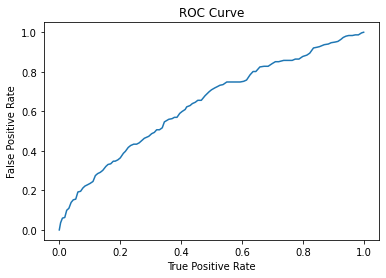

Training set areaUnderROC: 0.6372901362599135
Testing set areaUnderROC=0.639


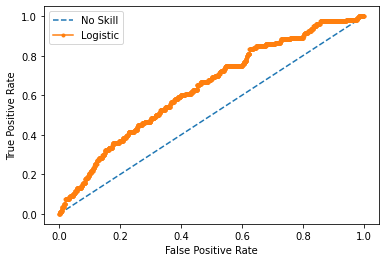

In [18]:
# AUC ROC for training set
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


# AUC ROC for test set
preds = predict_test.select('target','prob_int').rdd.map(lambda row: (float(row['prob_int']), float(row['target']))).collect()
lr_probs, y_test = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs, pos_label = 1)

ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Testing set areaUnderROC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [19]:
#calculating KS

#Creating deciles using the predcited probability column 
discretizer = QuantileDiscretizer(numBuckets=10, inputCol="prob_int", outputCol="PROB_BUCKET")
predict_train = discretizer.fit(predict_train).transform(predict_train)
predict_test = discretizer.fit(predict_test).transform(predict_test)

#Creating #Good & # bad for each decile 
ks_train = predict_train.groupby('PROB_BUCKET').agg(F.count("ID").alias("Total"), 
                                                    F.max("prob_int").alias("max_prob"), 
                                                    F.min("prob_int").alias("min_prob"),  
                                                    F.sum("target").alias("bads") ,
                                                    F.count(F.when(col("target") == 0,1)).alias("goods")).sort(col('PROB_BUCKET').desc())

ks_test = predict_test.groupby('PROB_BUCKET').agg(F.count("ID").alias("Total"), 
                                                  F.max("prob_int").alias("max_prob"), 
                                                  F.min("prob_int").alias("min_prob"),  
                                                  F.sum("target").alias("bads") ,
                                                  F.count(F.when(col("target") == 0,1)).alias("goods")).sort(col('PROB_BUCKET').desc())

#Creating %cumulative good,%cumulative bad & KS 
ks_train = ks_train.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('bads').over(Window.partitionBy()))
ks_train = ks_train.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('goods').over(Window.partitionBy()))
ks_train = ks_train.withColumn('%diff', F.col('%cumuBad') -  F.col('%cumuGood'))
ks_train = ks_train.withColumn('max_diff', F.when(F.col('%diff') ==F.max('%diff').over(Window.partitionBy()) ,'<----').otherwise(' '))

ks_test = ks_test.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('bads').over(Window.partitionBy()))
ks_test = ks_test.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('goods').over(Window.partitionBy()))
ks_test = ks_test.withColumn('%diff', F.col('%cumuBad') -  F.col('%cumuGood'))
ks_test = ks_test.withColumn('max_diff', F.when(F.col('%diff') ==F.max('%diff').over(Window.partitionBy()) ,'<----').otherwise(' '))

ks_train.sort(col('PROB_BUCKET').desc()).show()
ks_test.sort(col('PROB_BUCKET').desc()).show()

+-----------+-----+-----------+------------+----+-----+-------------------+-------------------+--------------------+--------+
|PROB_BUCKET|Total|   max_prob|    min_prob|bads|goods|           %cumuBad|          %cumuGood|               %diff|max_diff|
+-----------+-----+-----------+------------+----+-----+-------------------+-------------------+--------------------+--------+
|        9.0| 1767| 0.13853945| 0.028943837|  71| 1696|0.23509933774834438|0.09854735618826264| 0.13655198156008175|        |
|        8.0| 1762|0.028909806| 0.022836756|  39| 1723|0.36423841059602646|0.19866356769320162| 0.16557484290282484|        |
|        7.0| 1747| 0.02283603| 0.019426838|  35| 1712|0.48013245033112584| 0.2981406159209762| 0.18199183441014966|        |
|        6.0| 1735|0.019403204| 0.016964752|  33| 1702| 0.5894039735099338|0.39703660662405577| 0.19236736688587802|        |
|        5.0| 1753| 0.01695953|  0.01500702|  36| 1717| 0.7086092715231788|0.49680418361417783| 0.21180508790900093|  

In [ ]:
{
 'DAYS_EMPLOYEDbucket': 0.09953102010566758   
 'OCCUPATION_TYPE': 0.09005135568358584,
 'NAME_FAMILY_STATUS': 0.04313711542312794
 'FLAG_OWN_REALTY': 0.02744070350168345, 
 'CODE_GENDER': 0.025203504527450814, 
 'NAME_EDUCATION_TYPE': 0.010895022914241295,
 'NAME_INCOME_TYPE': 0.23649142142127452, 
 'NAME_HOUSING_TYPE': 0.007327502688022734,
 'AMT_INCOME_TOTALbucket': 0.0022134026915242517,

 'FLAG_OWN_CAR': 4.5424812499967504e-06,   
 'FLAG_MOBIL': 0.0, 
 'FLAG_WORK_PHONE': 0.00204242979514846, 
 'FLAG_PHONE': 0.0005480495762639285, 
 'FLAG_EMAIL': 1.7343581493999582e-05}

Training Dataset Count: 17512
Test Dataset Count: 7622


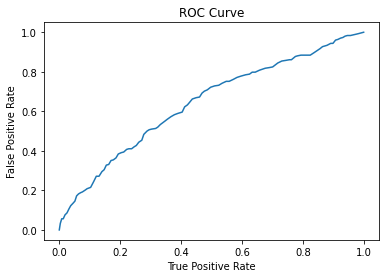

Training set areaUnderROC: 0.6409181863309105
Testing set areaUnderROC=0.645


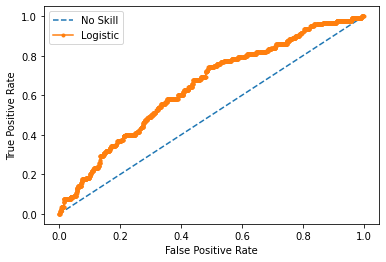

+-----------+-----+------------+------------+----+-----+------------------+-------------------+-------------------+--------+
|PROB_BUCKET|Total|    max_prob|    min_prob|bads|goods|          %cumuBad|          %cumuGood|              %diff|max_diff|
+-----------+-----+------------+------------+----+-----+------------------+-------------------+-------------------+--------+
|        9.0| 1767|  0.12712389| 0.028481252|  65| 1702|0.2152317880794702|0.09889599070307961|0.11633579737639058|        |
|        8.0| 1757|  0.02843718| 0.023106424|  51| 1706|0.3841059602649007| 0.1980244044160372| 0.1860815558488635|        |
|        7.0| 1744| 0.023104155|  0.01931368|  37| 1707|0.5066225165562914|0.29721092388146425|0.20941159267482717|        |
|        6.0| 1769| 0.019307673| 0.017139195|  27| 1742|0.5960264900662252|0.39843114468332363|0.19759534538290158|        |
|        5.0| 1734| 0.017136438| 0.014948291|  38| 1696|0.7218543046357616| 0.4969785008715863|0.22487580376417532|   <----|


In [28]:
#splitting in test and train data
train, test = encoded_df_saved.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

#Specifying feature list to be used for logistic regression
features_list = ['AMT_INCOME_TOTALbucket_woe','CODE_GENDER_woe','DAYS_EMPLOYEDbucket_woe','FLAG_OWN_REALTY_woe',
                 'NAME_EDUCATION_TYPE_woe','NAME_FAMILY_STATUS_woe','NAME_HOUSING_TYPE_woe','OCCUPATION_TYPE_woe',
                 'NAME_INCOME_TYPE_woe']

#Creating feature vector column with all the input variables
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

#Building logistic regression model and predict on test & train dataset using the same model 
lr = LogisticRegression(labelCol="target", featuresCol= "features",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
#predict_test.select("target","prediction","probability").show(truncate=False)

#Creating a probability column for target probability 
secondelement=udf(lambda v:float(v[1]),FloatType())
predict_train = predict_train.withColumn('prob_int', secondelement('probability'))
predict_test = predict_test.withColumn('prob_int', secondelement('probability'))

# AUC ROC for training set
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


# AUC ROC for test set
preds = predict_test.select('target','prob_int').rdd.map(lambda row: (float(row['prob_int']), float(row['target']))).collect()
lr_probs, y_test = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs, pos_label = 1)

ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Testing set areaUnderROC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


#calculating KS

#Creating deciles using the predcited probability column 
discretizer = QuantileDiscretizer(numBuckets=10, inputCol="prob_int", outputCol="PROB_BUCKET")
predict_train = discretizer.fit(predict_train).transform(predict_train)
predict_test = discretizer.fit(predict_test).transform(predict_test)

#Creating #Good & # bad for each decile 
ks_train = predict_train.groupby('PROB_BUCKET').agg(F.count("ID").alias("Total"), 
                                                    F.max("prob_int").alias("max_prob"), 
                                                    F.min("prob_int").alias("min_prob"),  
                                                    F.sum("target").alias("bads") ,
                                                    F.count(F.when(col("target") == 0,1)).alias("goods")).sort(col('PROB_BUCKET').desc())

ks_test = predict_test.groupby('PROB_BUCKET').agg(F.count("ID").alias("Total"), 
                                                  F.max("prob_int").alias("max_prob"), 
                                                  F.min("prob_int").alias("min_prob"),  
                                                  F.sum("target").alias("bads") ,
                                                  F.count(F.when(col("target") == 0,1)).alias("goods")).sort(col('PROB_BUCKET').desc())

#Creating %cumulative good,%cumulative bad & KS 
ks_train = ks_train.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('bads').over(Window.partitionBy()))
ks_train = ks_train.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('goods').over(Window.partitionBy()))
ks_train = ks_train.withColumn('%diff', F.col('%cumuBad') -  F.col('%cumuGood'))
ks_train = ks_train.withColumn('max_diff', F.when(F.col('%diff') ==F.max('%diff').over(Window.partitionBy()) ,'<----').otherwise(' '))

ks_test = ks_test.withColumn('%cumuBad', F.sum('bads').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('bads').over(Window.partitionBy()))
ks_test = ks_test.withColumn('%cumuGood', F.sum('goods').over(Window.orderBy(F.col('PROB_BUCKET').desc()).rowsBetween(Window.unboundedPreceding, 0)
)/ F.sum('goods').over(Window.partitionBy()))
ks_test = ks_test.withColumn('%diff', F.col('%cumuBad') -  F.col('%cumuGood'))
ks_test = ks_test.withColumn('max_diff', F.when(F.col('%diff') ==F.max('%diff').over(Window.partitionBy()) ,'<----').otherwise(' '))

ks_train.sort(col('PROB_BUCKET').desc()).show()
ks_test.sort(col('PROB_BUCKET').desc()).show()

In [29]:
#Creating prediction classs based on the prob cut off by KS value

min_prob_max_ks = ks_test.where(col("max_diff") == '<----').select(col("min_prob")).collect()[0]
predict_test = predict_test.withColumn('pred_class', F.when(F.col('prob_int') > round(min_prob_max_ks[0],4) ,1).otherwise(0))
predict_test.groupBy('pred_class','target').count().show()

#Generating evaluation metrics
results = predict_test.select(['pred_class', 'target'])
results = results.withColumn("target", results["target"].cast(DoubleType()))
results = results.withColumn("pred_class", results["pred_class"].cast(DoubleType()))

predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
metrics1 = BinaryClassificationMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
print(cm)
# Overall statistics
precision = metrics.precision(1)
recall = metrics.recall(1)
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
# Area under precision-recall curve
print("Area under PR = %s" % metrics1.areaUnderPR)
# Area under ROC curve
print("Area under ROC = %s" % metrics1.areaUnderROC)

+----------+------+-----+
|pred_class|target|count|
+----------+------+-----+
|         1|     0| 3691|
|         1|     1|   89|
|         0|     0| 3811|
|         0|     1|   31|
+----------+------+-----+

[[3811. 3691.]
 [  31.   89.]]
Summary Stats
Precision = 0.023544973544973546
Recall = 0.7416666666666667
F1 Score = 0.5116767252689582
Area under PR = 0.022537334780457757
Area under ROC = 0.6248322669510353
